# DONT RUN. OUTPUT WILL BE GONE

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.testing import (assert_equal, assert_almost_equal,
                           assert_array_equal, assert_array_almost_equal)

## Problem 1 [1 pt]

Create a function `get_reviews` that reads `/mnt/data/public/insideairbnb/data.insideairbnb.com/united-kingdom/scotland/edinburgh/2016-07-09/data/reviews.csv.gz` and returns a DataFrame with each row corresponding to a review. The index should be the review `id` and the first column should be the `reviewer_id`. The rest of the columns should be the TF-IDF representation of the review `comments`. The TF-IDF columns should be sorted alphabetically. 

Use `TfidfVectorizer` to create the TF-IDF representation. Convert the `comments` into lowercase first. For this problem, a word (token) is defined to be a sequence of alphabetical characters prefixed and suffixed by a word boundary. Consider only words that occur in at least 1000 reviews. Follow the idf definition in the previous lecture,
$$\text{idf}_w = \log{\frac{n}{n_w}},$$
Do not normalize the TF-IDF vector of each document. Do not include empty words ('') and drop rows that only have empty words. 

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer


class TFIDF:
    def __init__(self, df):
        """Store the idf of each column"""
        self.idf = np.log(df.shape[0] /
                          df[df > 0].notna().sum())

    def tfidf(self, values):
        """Standard values per column"""
        return values * self.idf


def get_reviews():
    """Return tf-idf representation of each review."""

    df = pd.read_csv('/mnt/data/public/insideairbnb/data.insideairbnb.com/'
                     'united-kingdom/scotland/edinburgh/2016-07-09/'
                     'data/reviews.csv.gz', compression='gzip')
    df = df[['id', 'reviewer_id', 'comments']].dropna(subset=['comments'])
    df.index = list(range(df.shape[0]))
    tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                       token_pattern=r'(?u)\b[A-Za-z]+\b',
                                       min_df=1000, use_idf=False,
                                       norm=None)
    bow_airbnb = tfidf_vectorizer.fit_transform(df['comments'])
    tfidf = pd.DataFrame(bow_airbnb.toarray(),
                         columns=tfidf_vectorizer.get_feature_names())
    tfidf = TFIDF(tfidf).tfidf(tfidf)
    tfidf = tfidf.loc[~(tfidf == 0).all(axis=1)]
    result = pd.merge(df, tfidf, how='right',
                      left_index=True, right_index=True)
    result = result.set_index('id').drop('comments', axis=1)
    return result

In [39]:
df_bow = get_reviews()
assert_array_equal(df_bow.columns[:10], 
                   ['reviewer_id', 'a', 'able', 'about', 'absolutely', 
                    'access', 'accessible', 'accommodating', 'accommodation', 
                    'accurate'])
assert_equal(df_bow.shape, (105390, 621))
assert_equal(df_bow.index[0], 60060297)
assert_equal(df_bow.iloc[0,0], 17059927)
assert_array_equal(df_bow.iloc[0,:].to_numpy().nonzero()[0], 
                   [  0,   7,  25,  65, 123, 193, 206, 213, 245, 274, 333, 
                    353, 358, 362, 402, 450, 466, 495, 511, 519, 569, 582, 
                    588, 589, 595])
assert_almost_equal(df_bow.iloc[0, 7], 3.1663363011050603)

2:40: W291 trailing whitespace
3:71: W291 trailing whitespace
4:78: W291 trailing whitespace
8:27: E231 missing whitespace after ','
9:33: E231 missing whitespace after ','
9:61: W291 trailing whitespace
10:21: E201 whitespace after '['
10:75: W291 trailing whitespace
11:21: E128 22
11:75: W291 trailing whitespace
12:21: E128 22


## Problem 2 [1 pt]

Create a function `closest_euc` that accepts `df_bow` and returns the 10 closest review `id`s by increasing Euclidean distance from review `id` `80416123`, precision and recall. A result is considered relevant if it comes from the same `review_id` as the query (`reviewer_id == 24782827`).

In [48]:
from scipy.spatial.distance import cdist


def closest_euc(df_bow):
    """Return the ten closest reviews to id 80416123, along with"""

    #  relevant if `reviewer_id` == 24782827
    relevant_ids = df_bow[df_bow['reviewer_id'] == 24782827].index
    df_bow_new = df_bow.reset_index('id')

    #  filter query
    query = df_bow_new[df_bow_new['id'] == 80416123]

    #  get euclidean distance of query to each review
    result_dist = cdist(query.iloc[:, 2:],
                        df_bow_new.iloc[:, 2:], metric='euclidean')[0]

    #  generate indices of the top 10 closest reviews
    #  this includes the same review with id 80416123
    top_10 = df_bow.index[result_dist.argsort()[:10]]

    #  get the ids of the returned results
    returned_ids = df_bow_new[df_bow_new['id'].isin(top_10)]['id'].values

    #  construct confusion matrix using relevant and returned data
    tp = np.isin(returned_ids, relevant_ids).sum()
    fp = len(returned_ids) - np.isin(returned_ids, relevant_ids).sum()
    fn = len(relevant_ids) - np.isin(relevant_ids, returned_ids).sum()
    tn = df_bow_new.shape[0] - tp - fp - fn

    # calculate for precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return returned_ids, precision, recall

In [49]:
closest_ids_euc, p_euc, r_euc = closest_euc(df_bow)
assert_equal(len(closest_ids_euc), 10)

## Problem 3 [1 pt]

Create a function `compute_auc_euc` that accepts `df_bow` and returns the AUC distance when the review `id` `80416123` is the query and Euclidean distance is the metric. A result is considered relevant if it comes from the same `review_id` as the query (`reviewer_id == 24782827`).

In [56]:
from scipy.spatial.distance import euclidean


def nearest_k(query, objects, k, dist):
    """Return the indices to objects most similar to query

    Parameters
    ----------
    query : ndarray
        query object represented in the same form vector representation as the
        objects
    objects : ndarray
        vector-represented objects in the database; rows correspond to
        objects, columns correspond to features
    k : int
        number of most similar objects to return
    dist : function
        accepts two ndarrays as parameters then returns their distance

    Returns
    -------
    most_similar : ndarray
        Indices to the most similar objects in the database
    """
    return np.argsort([dist(query, obj) for obj in objects])[:k]


def pr_curve(query, objects, dist, actual, all_labels):
    """Return the precision-recall curve for a given query."""
    all_labels = np.asarray(all_labels)
    results = nearest_k(query, objects, len(all_labels), dist)
    rs = (all_labels[results] == actual).cumsum()
    N = (all_labels == actual).sum()
    precisions = rs / np.arange(1, len(rs)+1)
    recalls = rs / N
    recalls = [0] + recalls.tolist()
    precisions = [1] + precisions.tolist()
    return np.trapz(precisions, recalls)


def compute_auc_euc(df_bow):
    """Calculate AUC for precision-recall values, using Euclidean distance."""
    label = df_bow['reviewer_id']
    objects = df_bow.iloc[:, 1:]
    query = df_bow[df_bow.index == 80416123].iloc[:, 1:]
    query_label = df_bow[df_bow.index == 80416123].iloc[:, 0].values[0]
    auc = pr_curve(query.to_numpy(), objects.to_numpy(),
                   euclidean, query_label, label.to_list())
    return auc

In [57]:
auc_euc = compute_auc_euc(df_bow)

## Problem 4 [2 pts]

Create a function `closest_quote_cos` that accepts `df_bow` and returns the 10 closest review `id`s by increasing cosine distance from the text "Great place in the heart of the city."

In [65]:
from scipy.spatial.distance import cdist


def closest_quote_cos(df_bow):
    """Return ten reviews with smallest cosine distance from a given text."""
    df_bow = df_bow.reset_index('id')
    df_bow = df_bow.set_index(['id', 'reviewer_id'])

    #  reverting tfidf back to a term-frequency matrix by dividing each
    #  score by their corresponding idf values
    orig_n = 106054
    nw = np.count_nonzero(df_bow, axis=0)
    idf = np.log(orig_n/nw)
    df_bow = df_bow / idf
    df_bow = df_bow.reset_index('reviewer_id')

    #  adding the term frequency scores of the text query in the corpus
    text = ["Great place in the heart of the city."]
    tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                       token_pattern=r'(?u)\b[A-Za-z]+\b',
                                       use_idf=False, norm=None)
    text_tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf = pd.DataFrame(text_tfidf.toarray(),
                         columns=tfidf_vectorizer.get_feature_names())
    tfidf['reviewer_id'] = 'query'
    df_bow_new = pd.concat([df_bow, tfidf]).fillna(0)

    #  reconstructing the tfidf matrix with the query in it
    df_bow_new = df_bow_new.set_index('reviewer_id')
    nw = np.count_nonzero(df_bow_new, axis=0)
    idf = np.log((orig_n+1)/nw)
    df_bow_new = df_bow_new * idf
    df_bow_new = df_bow_new.reset_index('reviewer_id')

    #  filtering the query and calculating the cosine distance of the
    #  query vector relative to all other vectors, except the query since
    #  query is not part of the original corpus
    query = df_bow_new[df_bow_new['reviewer_id'] == 'query'].iloc[:, 1:]
    result_dist = cdist(query, df_bow_new.iloc[:-1, 1:], metric='cosine')[0]

    #  generate ids of top 10 most similar with the text query
    top_10 = df_bow.index[result_dist.argsort()[:10]]
    return top_10

In [66]:
closest_ids_quote = closest_quote_cos(df_bow)
assert_equal(len(closest_ids_quote), 10)

## Problem 5 [1 pt]
Perform dimensionality reduction on `df_jokes` using one of the methods discussed in class.

To be able to generate meaningful themes among the customer reviews in AirBnB, it is important to first remove both English and French stop words as some of the reviews in the corpus are in French. To do this, we load the `STOP_WORDS` of the `spacy` library for both the French and English language.

Likewise, this analysis would only consider words that are alphabetical (i.e. no numbers or any punctuation/special characters) that have a length of 3 characters of more. In order to also consider the collocations and dependence of words among each other, this analysis would also allow tokens to be bigrams (aside from just taking unigrams into consideration). Lastly, the tf-idf matrix only includes words that appear in at least 1% of all reviews but not more than 70% of all reviews.

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
import warnings
warnings.filterwarnings('ignore')


def cleaner_tfidf():
    """Return a tf-idf matrix that removes all English and French stopwords.

    This tf-idf matrix also excludes words that consists of less than three
    alphabetical characters, and only includes words that appear in at
    at least 1% of all reviews but not more than 70% of all reviews.
    Likewise, this tf-idf matrix allows for the possibility of bigrams when
    tokenizing the text.

    Returns
    -------
    tfidf : pandas.DataFrame
        A pandas dataframe containing the corresponding tf-idf scores of
        each word in a review.
    """
    stopwords_list = list(fr_stop) + list(en_stop)
    df = pd.read_csv('/mnt/data/public/insideairbnb/data.insideairbnb.com/'
                     'united-kingdom/scotland/edinburgh/2016-07-09/'
                     'data/reviews.csv.gz', compression='gzip')
    df = df[['id', 'reviewer_id', 'comments']].dropna(subset=['comments'])
    df.index = list(range(df.shape[0]))
    tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                       stop_words=stopwords_list,
                                       token_pattern=r'(?u)\b[a-z]{3,}\b',
                                       ngram_range=(1, 2),
                                       min_df=0.01, max_df=0.7)
    bow_airbnb = tfidf_vectorizer.fit_transform(df['comments'])
    tfidf = pd.DataFrame(bow_airbnb.toarray(),
                         columns=tfidf_vectorizer.get_feature_names())
    return tfidf


tfidf = cleaner_tfidf()
tfidf

,able,absolutely,access,accessible,accommodating,accommodation,accurate,advice,airbnb,airbnb experience,...,windows,wine,wish,wonderful,wonderful host,wonderful stay,wonderful time,work,worked,worth
0,0.000000,0.000000,0.0,0.0,0.357504,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.240939,0.0,0.0,0.0,0.235878,0.321999,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.181579,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.142402,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106049,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.235025,0.0,0.140926,0.0,0.0,0.0,0.000000,0.0,0.0
106050,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.244956,0.0,0.0
106051,0.209854,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
106052,0.000000,0.326175,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [71]:
import scipy


def get_min_svs(X):
    """Return the explained variance information of the design matrix."""
    svs = scipy.linalg.svdvals(X)
    svs_exp = svs / svs.sum()
    svs_cum_exp = svs_exp.cumsum()
    return svs_exp, svs_cum_exp


exp_var, cum_exp_var = get_min_svs(tfidf)

In [72]:
def plot_var_explained(exp_var, cum_exp_var, thresh):
    """Visualize the amount of explained variance per singular value."""
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(list(range(1, 507)), exp_var, color='dodgerblue')
    ax1.set_ylabel('Explained Variance')
    ax1.set_xlabel('SVD')
    ax2 = ax1.twinx()
    ax2.plot(list(range(1, 507)), cum_exp_var, color='green')
    ax2.set_ylabel('Cumulative Variance')
    fig = plt.suptitle('Variance Explained by Singular Values '
                       '- AirBnB Dataset\n', fontsize=16)
    fig = plt.axvline(np.where(exp_var.cumsum() >= thresh)[0][0] + 1,
                      alpha=0.5, color='red', linestyle='--')
    fig = plt.axhline(thresh, alpha=0.5, color='red', linestyle='--')
    return fig

In [73]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=min_svs)
tfidf_new = svd.fit_transform(tfidf)
min_svs = np.where(exp_var.cumsum() >= 0.75)[0][0]

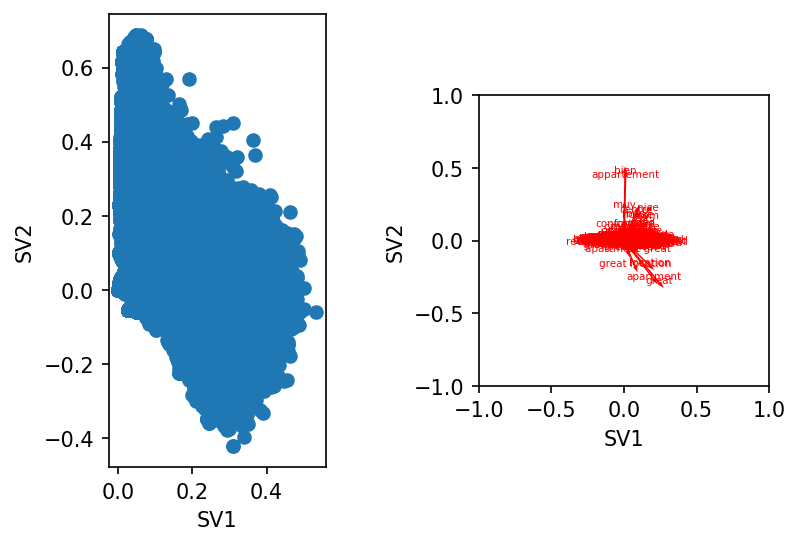

In [78]:
p = svd.components_.T
feature_names = tfidf.columns
plot_svd(tfidf_new, feature_names, p);

In [79]:
def LSA_plot(p, coefs, color, title):
    """Visualize the Top 6 singular values after latent semantic analysis."""
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
    ax = ax.flatten()
    for i in range(6):
        order = np.argsort(np.abs(p[:, i]))[-10:]
        ax[i].barh([coefs[o] for o in order], p[order, i],
                   color=color)
        ax[i].set_title(f'SV{i+1}')
    fig = plt.suptitle(title, fontsize=14)
    fig = plt.tight_layout()
    return fig, ax

## Problem 6 [1 pt]

Justify your choice of dimensionality reduction method.

Since I am working with text data, the tfidf matrix that I would be generating after transforming the AirBnB listing reviews into structured format is expected to be sparse. Since this is the case, I must use a dimensionality reduction technique that does not require my data to be mean-centered (as doing so would make the transformation process much longer since the tfidf matrix already became dense). Hence, it is more appropriate to use the truncated singular value decomposition (SVD) as this does not require my data to be mean-centered in order to proceed with the transformation.

## Problem 7 [1 pt]

How many dimensions did you retain? Justify your choice.

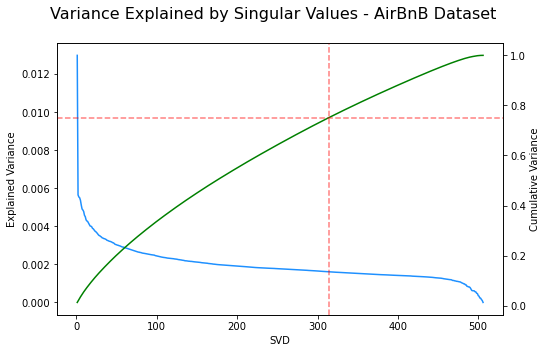

In [80]:
plot_var_explained(exp_var, cum_exp_var, 0.75);

Since my resulting tfidf matrix had generated 506 columns, I would like to be able to reduce it such the resulting transformation from Truncated SVD still explains a significant amount of the variation in the original matrix. From the visualization above, we could see that 75% of the variance in the entire tfidf matrix is accounted for by 313 singular values. Hence, I retained 313 dimensions in the dataset and then implemented latent semantic analysis in order to identify underlying themes between a set of documents (in this case, the customer reviews) and the terms that each document contain. 

## Problem 8 [2 pts]

Interpret the results of the dimensionality reduction.

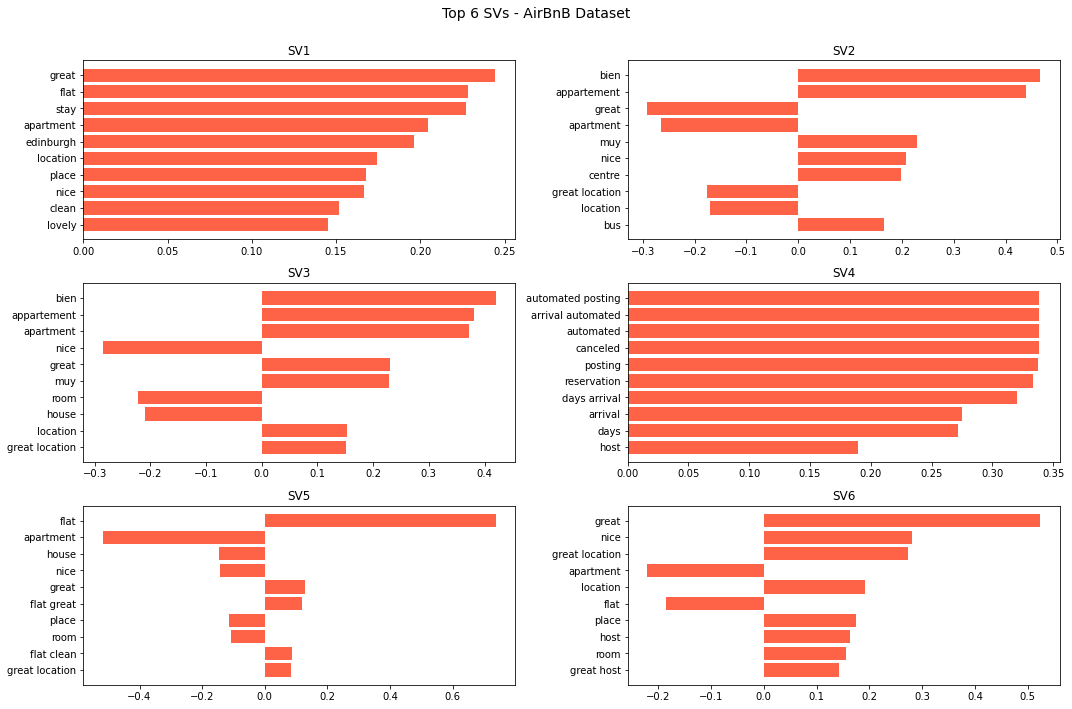

In [25]:
p = svd.components_.T
feature_names = tfidf.columns
LSA_plot(p, feature_names, 'tomato', 'Top 6 SVs - AirBnB Dataset\n');

For easier appreciation, I visualized the weights for each singular vector as there are a lot of original features (hence it is hard to read the labels and the arrows). We can see that each singular value discusses a specific theme about AirBnBs. The first singular value discusses the over-all experience of tourists when they go to AirBnBs in Edinburgh, United Kingdom. Generally, tourists that went to this city have stayed in flats or apartments and had a relatively good experience during their stay. Most of their affirmative feedback is related to the cleanliness of the place. The second singular value talks about the location of the AirBnBs and how this provides convenience to the tourists as most of the apartments in Edinburgh are located at the center (where most tourist activity generally takes place). It is also convenient in the sense that it is near different modes of transportation such as buses.

The third singular value creates a spectrum among houses and apartments. In the positive axis, the convenience provided by apartments in terms of location is being talked about here. On the other hand, the negative axis of the third singular value talks about how nice the different rooms in a house are. 

The fourth singular value revolves around themes that could possibly lead to customer disatisfaction, such as the cancellation of AirBnB reservations along with the automated posting of cancellations done by AirBnB whenever hosts tend to cancel pre-booked reservations. 

The fifth singular value shows a spectrum among flats and apartments/houses. On the positive axis, the cleanliness and the strategic location of all flats in Edinburgh are being discussed. On the negative axis, comments about how nice the rooms are in the apartments/houses are given.

Lastly, the sixth singular value talks about the importance of having a good host that would provide the tourists convenience (in terms of the setting up the reservation, and making sure that cancellations are avoided) along with a good AirBnB experience (by ensuring that the host would make the rooms clean).

From these six singular values, we can conclude that the cleanliness of the AirBnB, the strategicness of its location (in particular, how close it is to the center), along with the cooperativeness of the hosts in providing their customers a good experience, are considerations that tourists take into account when choosing an AirBnB at  Edinburgh.